In [4]:
import numpy as np
import wandb
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import shutil
import os                              # Import the 'os' module for changing directories
os.chdir('/content/drive/MyDrive/FL')  # Change the directory

Mounted at /content/drive


In [5]:
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR100
from torch.utils.data import Subset, DataLoader, random_split

from FederatedLearningProject.data.cifar100_loader import get_cifar100
import FederatedLearningProject.checkpoints.checkpointing as checkpointing
from FederatedLearningProject.training.FL_training import train_server_model_editing
from FederatedLearningProject.experiments import models

In [6]:
### TRAIN SPLIT WITH EVALUATION ###

valid_split_perc = 0.2
train_set, val_set, test_set = get_cifar100(valid_split_perc=valid_split_perc)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

Number of images in Training Set:   40000
Number of images in Validation Set: 10000
Number of images in Test Set:       10000
✅ Datasets loaded successfully


In [7]:
model = models.LinearFlexibleDino(num_layers_to_freeze=12)
model_checkpoint = torch.load("FederatedLearningProject/checkpoints/FL_IID_300round/dino_vits_16_iid_local_steps_4_checkpoint.pth")
model.load_state_dict(model_checkpoint['model_state_dict'])
model.to_cuda()


Downloading: "https://github.com/facebookresearch/dino/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 113MB/s]


moving model to cuda


In [8]:
model.debug()


--- Debugging Model ---
Model is primarily on device: cuda:0
Model overall mode: Train

Parameter Details (Name | Device | Requires Grad? | Inferred Block | Module Mode):
- backbone.cls_token                                 | cuda:0     | False           | N/A             | Train
- backbone.pos_embed                                 | cuda:0     | False           | N/A             | Train
- backbone.patch_embed.proj.weight                   | cuda:0     | False           | N/A             | Train
- backbone.patch_embed.proj.bias                     | cuda:0     | False           | N/A             | Train
- backbone.blocks.0.norm1.weight                     | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.norm1.bias                       | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.attn.qkv.weight                  | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.attn.qkv.bias                    | cuda:0

In [12]:
num_clients = 100
from FederatedLearningProject.data.cifar100_loader import create_iid_splits
client_dataset_iid = create_iid_splits(train_set, num_clients = num_clients)

Dataset has 40000 samples across 100 classes.
Creating 100 IID splits with 100 classes each.


Each of the 100 classes split into 100 shards.

Checking unique classes that each client sees:
Client 0 has samples from classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24), np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32), np.int64(33), np.int64(34), np.int64(35), np.int64(36), np.int64(37), np.int64(38), np.int64(39), np.int64(40), np.int64(41), np.int64(42), np.int64(43), np.int64(44), np.int64(45), np.int64(46), np.int64(47), np.int64(48), np.int64(49), np.int64(50), np.int64(51), np.int64(52), np.int64(53), np.int64(54), np.int64(55), 

In [35]:
# ..............FEDERATED IID..................
# importiamo il modello migliore: best_model
import time
from FederatedLearningProject.training.model_editing import compute_mask, get_n_examples_per_class_loader, print_info_dataloader, plot_all_layers_mask_sparsity, plot_qkv_weight_bias_sparsity

def compute_mask_clients(model,
                         client_dataset,
                         num_classes,
                         n_per_class,
                         batch_size=128,
                         final_sparsity=0.9,
                         tot_rounds=10,
                         soft_zero=0.01,
                         num_examples=25,
                         debug = False):

  client_masks = []
  for i in range(len(client_dataset)):
    client_loader = DataLoader(client_dataset[i], batch_size=128, shuffle=True, num_workers=2)

    # 1. Definiamo il dataloader stratificato per allenare la maschera
    # il train_loader è quello locale del client
    if debug:
      print_info_dataloader(client_loader)

    # In FED IID:
    stratified_loader = get_n_examples_per_class_loader(client_loader, num_classes=num_classes, n_per_class=n_per_class) # num_classes * n_per_class to be constant
    if debug:
      print_info_dataloader(stratified_loader)

    # 2. Alleniamo la maschera su 25 esempi (100 in realtà)
    #start = time.time()
    mask = compute_mask(model, stratified_loader, sparsity_target=final_sparsity, R=tot_rounds, num_examples=num_examples, soft_zero=soft_zero, device='cuda', enable_plot=0, debug=False) # num_examples=None : sfoglia tutto il dataset passato in ingresso (già ridotto)
    #end = time.time()
    if debug:
      plot_all_layers_mask_sparsity(mask)
      plot_qkv_weight_bias_sparsity(mask)
      print(f"Mask computation time: {end-start}")
      print(f"Sparsity target: {final_sparsity}")
      print(f"Soft Zero Value: {soft_zero}")
      print(f"Rounds: {tot_rounds}")
      print(f"Num_examples: {num_examples}")

    client_masks.append(mask)

  return client_masks



In [33]:
import os
print(os.getcwd())

/content/drive/MyDrive/FL


In [16]:
client_masks_iid = compute_mask_clients(model, client_dataset_iid, num_classes=100, n_per_class=1)

In [32]:
torch.save(client_masks_iid, "FederatedLearningProject/masks/client_masks_iid.pth")

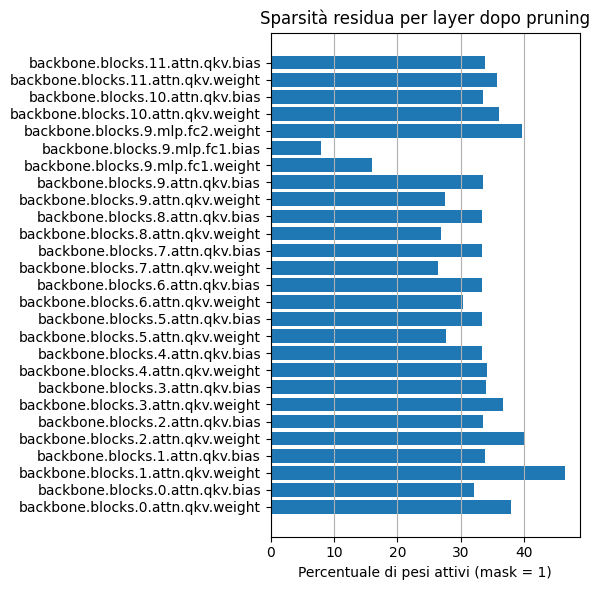

In [30]:
plot_all_layers_mask_sparsity(client_masks_iid[65])

In [41]:
model_non_iid_1 = models.LinearFlexibleDino(num_layers_to_freeze=12)
model_checkpoint_non_iid_1 = torch.load("FederatedLearningProject/checkpoints/FL_NON_IID(1)_bs128/dino_vits_16_non_iid(1)_local_steps_4_bs128_checkpoint.pth")
model_non_iid_1.load_state_dict(model_checkpoint_non_iid_1['model_state_dict'])


Using cache found in /root/.cache/torch/hub/facebookresearch_dino_main


<All keys matched successfully>

In [42]:
from FederatedLearningProject.data.cifar100_loader import create_non_iid_splits
client_dataset_non_iid_1 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 1)

Dataset has 40000 samples across 100 classes.
Creating 100 non IID splits with 1 classes each.


Each of the 100 classes split into 1 shards.

Checking unique classes that each client sees:
Client 0 has samples from classes: {np.int64(0)}
Total: 1
Client 1 has samples from classes: {np.int64(1)}
Total: 1
Client 2 has samples from classes: {np.int64(2)}
Total: 1
Client 3 has samples from classes: {np.int64(3)}
Total: 1
Client 4 has samples from classes: {np.int64(4)}
Total: 1
Client 5 has samples from classes: {np.int64(5)}
Total: 1
Client 6 has samples from classes: {np.int64(6)}
Total: 1
Client 7 has samples from classes: {np.int64(7)}
Total: 1
Client 8 has samples from classes: {np.int64(8)}
Total: 1
Client 9 has samples from classes: {np.int64(9)}
Total: 1
Client 10 has samples from classes: {np.int64(10)}
Total: 1
Client 11 has samples from classes: {np.int64(11)}
Total: 1
Client 12 has samples from classes: {np.int64(12)}
Total: 1
Client 13 has samples from classes: {np.int64(13)}

In [ ]:
start = time.time()
client_masks_non_iid_1 = compute_mask_clients(client_dataset=client_dataset_non_iid_1, num_classes=1, n_per_class=100)
end = time.time()

In [ ]:
model.debug()

In [13]:
from FederatedLearningProject.data.cifar100_loader import create_non_iid_splits
client_dataset_non_iid_5 = create_non_iid_splits(train_set, num_clients = num_clients, classes_per_client = 5)


Dataset has 40000 samples across 100 classes.
Creating 100 non IID splits with 5 classes each.


Each of the 100 classes split into 5 shards.

Checking unique classes that each client sees:
Client 0 has samples from classes: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)}
Total: 5
Client 1 has samples from classes: {np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)}
Total: 5
Client 2 has samples from classes: {np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14)}
Total: 5
Client 3 has samples from classes: {np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19)}
Total: 5
Client 4 has samples from classes: {np.int64(20), np.int64(21), np.int64(22), np.int64(23), np.int64(24)}
Total: 5
Client 5 has samples from classes: {np.int64(25), np.int64(26), np.int64(27), np.int64(28), np.int64(29)}
Total: 5
Client 6 has samples from classes: {np.int64(32), np.int64(33), np.int64(34), np.int64(30), np.int64(31)}
Total: 5
Client 7 has sa

In [ ]:
# --- OPTIMIZER AND LOSS FUNCTION ---

lr = 0.01  # best hyperparameter of the centralized
momentum = 0.9
weight_decay = 0.0001 # best hyperparameter of the centralized

num_clients = 100

# Default hyperparameters for FedAvg
num_local_steps = 4 #
# num_local_steps = 8 #
# num_local_steps = 16 #
fraction = 0.1
criterion = nn.CrossEntropyLoss()

model_name = "prova_model_editing"

checkpoint_dir = "/content/drive/MyDrive/FL/FederatedLearningProject/checkpoints/FL/"
os.makedirs(checkpoint_dir, exist_ok=True)
# Make checkpoint path unique to the run if you want to store separate checkpoints
checkpoint_path = os.path.join(checkpoint_dir, "prova_checkpoint.pth")

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
model.to_cuda()

moving model to cuda


In [ ]:
from FederatedLearningProject.data.cifar100_loader import create_iid_splits
client_dataset = create_iid_splits(train_set, num_clients = num_clients)

In [ ]:
torch.save("FederatedLearningProject/masks/client_masks_iid.pth")

In [ ]:
train_server(model=model,
             num_clients = 10,
             num_rounds=1,
             client_dataset = client_dataset,
             frac=fraction,
             lr = lr,
             val_loader = val_loader,
             criterion = criterion,
             num_client_steps = 4,
             model_name = model_name,
             weight_decay = weight_decay,
             momentum = momentum,
             checkpoint_path = checkpoint_path,
             device = device)

--- Starting Round 1/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.3690
Round Target: 0.3690 (7858234 weights)
Total considered params: 21293568
Already pruned: 0. Active: 21293568
Need to prune 7858234 more weights from the active set.
threshold:2.3732052056857356e-07
Achieved cumulative sparsity in final mask: 0.3690
-------------------------

--- Starting Round 2/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.6019
Round Target: 0.6019 (12816445 weights)
Total considered params: 21293568
Already pruned: 7858235. Active: 13435333
Need to prune 4958210 more weights from the active set.
threshold:9.539007532882419e-19
Achieved cumulative sparsity in final mask: 0.6019
-------------------------

--- Starting Round 3/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.7488
Round Target: 0.7488 (15944865 weights)
Total considered params: 21293568
Already pruned: 12816446. Active: 8477122
Need to pru

{'model': LinearFlexibleDino(
   (backbone): VisionTransformer(
     (patch_embed): PatchEmbed(
       (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
     )
     (pos_drop): Dropout(p=0.0, inplace=False)
     (blocks): ModuleList(
       (0-11): 12 x Block(
         (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (attn): Attention(
           (qkv): Linear(in_features=384, out_features=1152, bias=True)
           (attn_drop): Dropout(p=0.0, inplace=False)
           (proj): Linear(in_features=384, out_features=384, bias=True)
           (proj_drop): Dropout(p=0.0, inplace=False)
         )
         (drop_path): Identity()
         (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
         (mlp): Mlp(
           (fc1): Linear(in_features=384, out_features=1536, bias=True)
           (act): GELU(approximate='none')
           (fc2): Linear(in_features=1536, out_features=384, bias=True)
           (drop): Dropout(p=0.0, inplace=False)
  

In [ ]:
torch.save("FederatedLearningProject/masks/client_masks.pth")

In [ ]:
model.debug()


--- Debugging Model ---
Model is primarily on device: cuda:0
Model overall mode: Train

Parameter Details (Name | Device | Requires Grad? | Inferred Block | Module Mode):
- backbone.cls_token                                 | cuda:0     | False           | N/A             | Train
- backbone.pos_embed                                 | cuda:0     | False           | N/A             | Train
- backbone.patch_embed.proj.weight                   | cuda:0     | False           | N/A             | Train
- backbone.patch_embed.proj.bias                     | cuda:0     | False           | N/A             | Train
- backbone.blocks.0.norm1.weight                     | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.norm1.bias                       | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.attn.qkv.weight                  | cuda:0     | False           | Block 0         | Eval
- backbone.blocks.0.attn.qkv.bias                    | cuda:0

In [ ]:
masks = compute_mask_clients(model, client_dataset)

--- Starting Round 1/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.3690
Round Target: 0.3690 (7858234 weights)
Total considered params: 21293568
Already pruned: 0. Active: 21293568
Need to prune 7858234 more weights from the active set.
threshold:0.008814557455480099
Achieved cumulative sparsity in final mask: 0.3690
-------------------------

--- Starting Round 2/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.6019
Round Target: 0.6019 (12816445 weights)
Total considered params: 21293568
Already pruned: 7858235. Active: 13435333
Need to prune 4958210 more weights from the active set.
threshold:1.6433132259408012e-05
Achieved cumulative sparsity in final mask: 0.6019
-------------------------

--- Starting Round 3/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.7488
Round Target: 0.7488 (15944865 weights)
Total considered params: 21293568
Already pruned: 12816446. Active: 8477122
Need to prun

In [ ]:
a = compute_mask(model, dataloader=DataLoader(client_dataset[0], batch_size=128, shuffle=True, num_workers=2))

--- Starting Round 1/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.3690
Round Target: 0.3690 (7858234 weights)
Total considered params: 21293568
Already pruned: 0. Active: 21293568
Need to prune 7858234 more weights from the active set.
threshold:7.881801866460592e-05
Achieved cumulative sparsity in final mask: 0.3690
-------------------------

--- Starting Round 2/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.6019
Round Target: 0.6019 (12816445 weights)
Total considered params: 21293568
Already pruned: 7858235. Active: 13435333
Need to prune 4958210 more weights from the active set.
threshold:2.6095978000739706e-07
Achieved cumulative sparsity in final mask: 0.6019
-------------------------

--- Starting Round 3/5 ---
Computing Fisher diagonal with current mask...
Current sparsity level: 0.7488
Round Target: 0.7488 (15944865 weights)
Total considered params: 21293568
Already pruned: 12816446. Active: 8477122
Need to pru

In [ ]:
count_masked_params(masks[0])

Total parameters: 21293568
Masked parameters (zeros): 19164212
Unmasked parameters (ones): 2129356


(21293568, 19164212, 2129356)

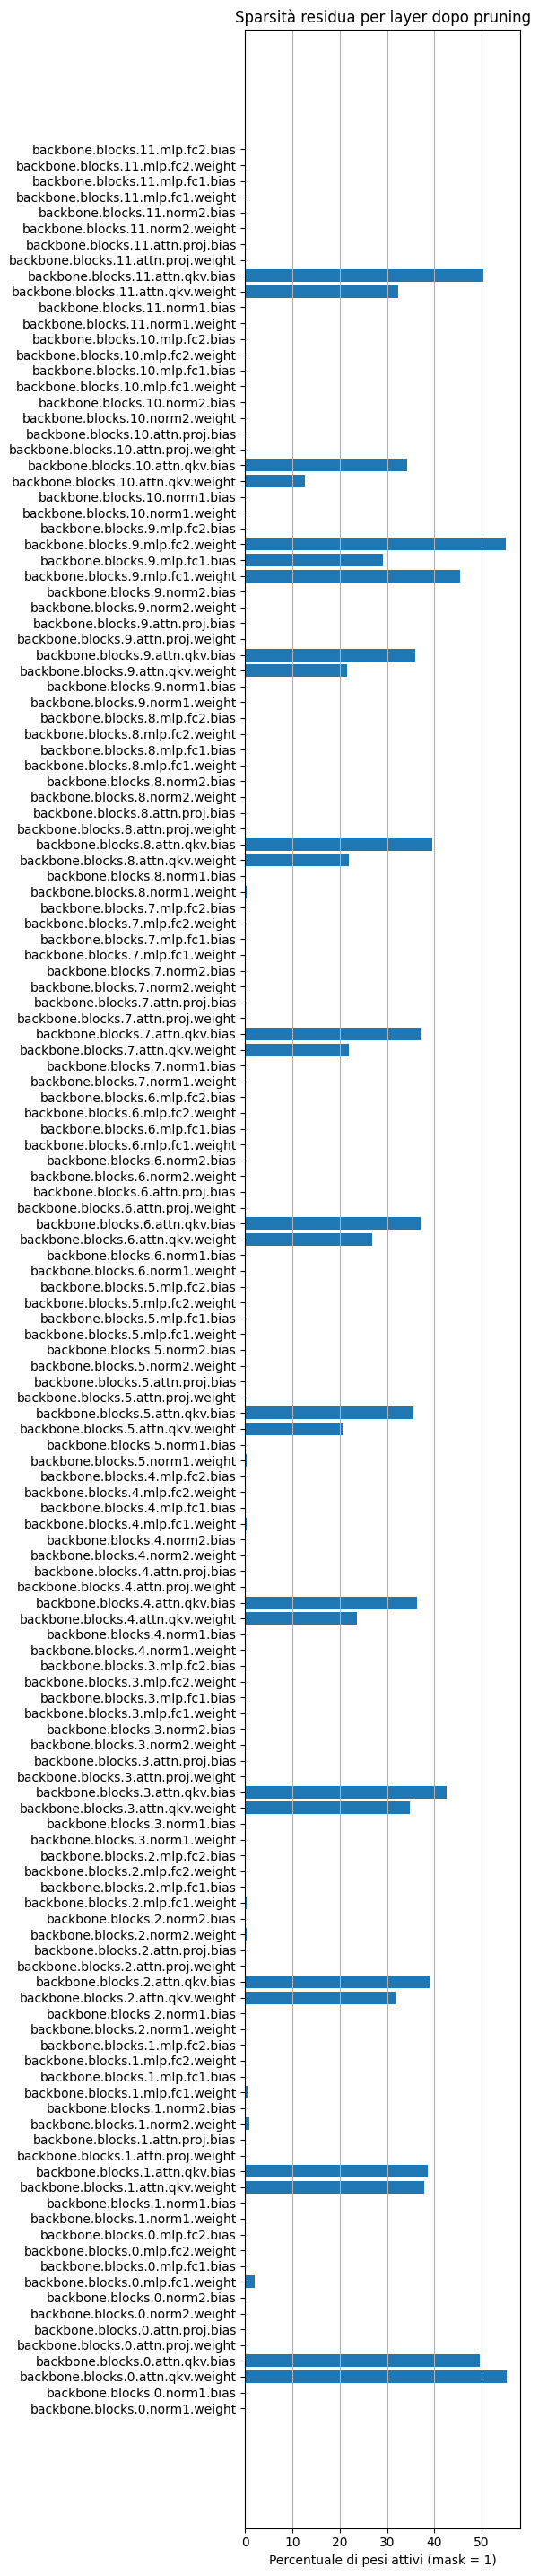

In [ ]:
plot_all_layers_mask_sparsity(masks[0])

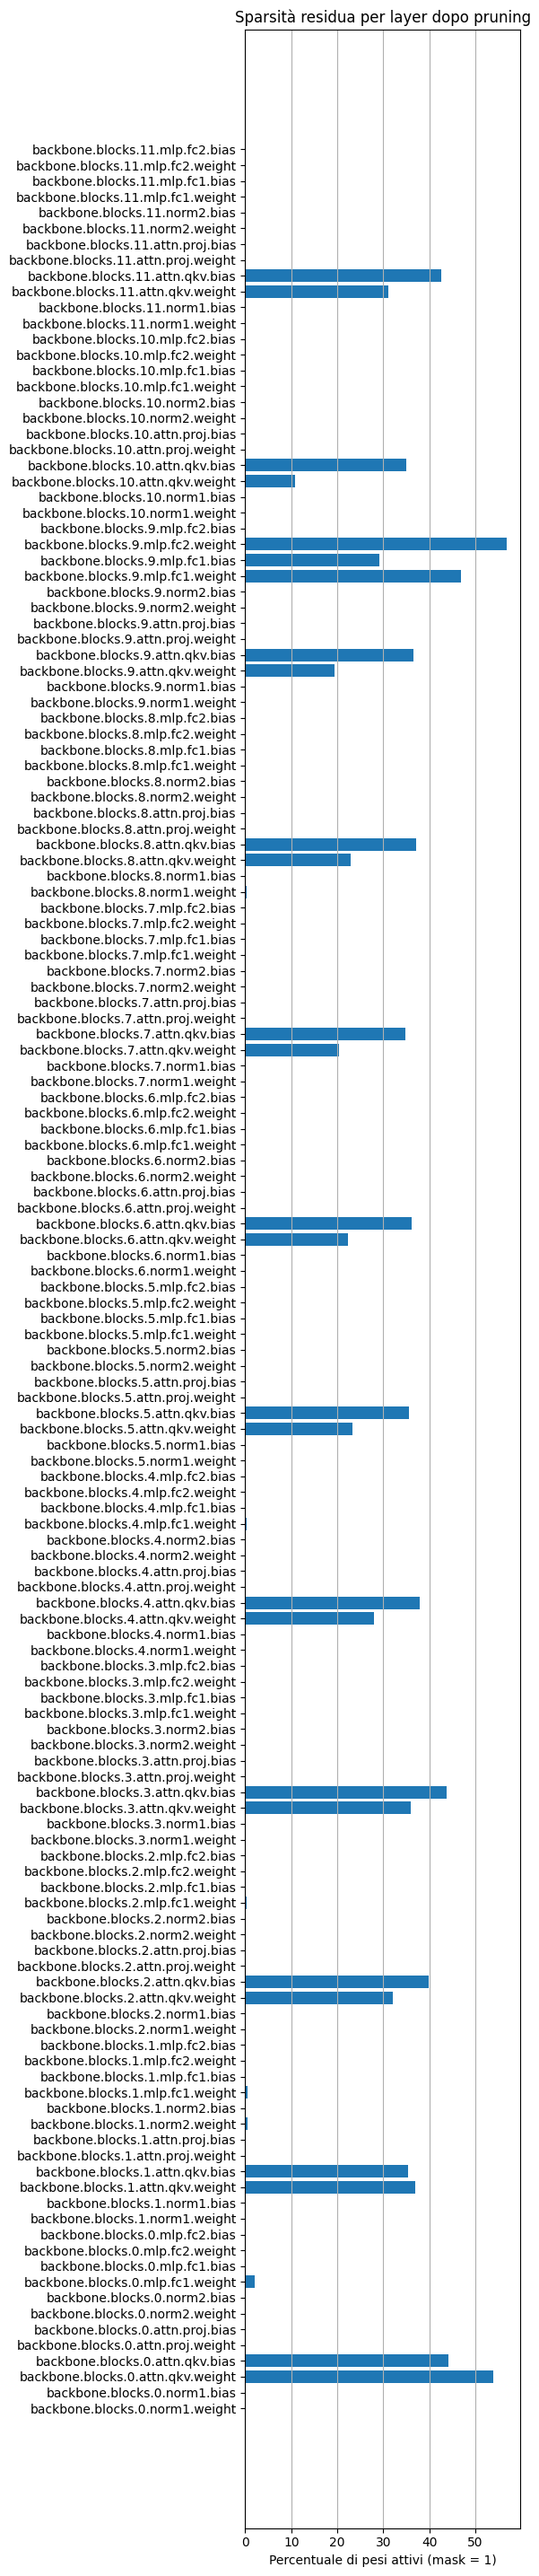

In [ ]:
plot_all_layers_mask_sparsity(masks[1])

In [ ]:
torch.save()